In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy
import scipy.fftpack
import scipy.io as sio
import copy
import pylab as pl
import time
from IPython import display
from matplotlib.pyplot import figure
from termcolor import colored

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Sep 06 07:15:46 2018', '__version__': '1.0', '__globals__': [], 'signal': array([[ 0.53766714],
       [ 0.03756843],
       [ 0.14573716],
       ...,
       [ 0.12946376],
       [-0.31268262],
       [-1.12638296]]), 'signalFIR': array([[ 0.00022914],
       [-0.00132187],
       [-0.00286959],
       ...,
       [ 0.02237262],
       [ 0.0109556 ],
       [-0.00048004]]), 'signalMW': array([[ 0.03076206],
       [ 0.0328479 ],
       [ 0.0348915 ],
       ...,
       [-0.00364748],
       [-0.00341268],
       [-0.00317421]]), 'srate': array([[2048]], dtype=uint16)}
dict_keys(['__header__', '__version__', '__globals__', 'signal', 'signalFIR', 'signalMW', 'srate'])
2048


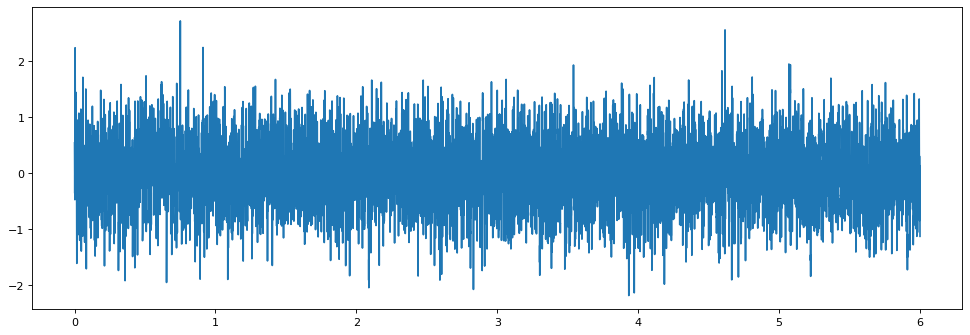

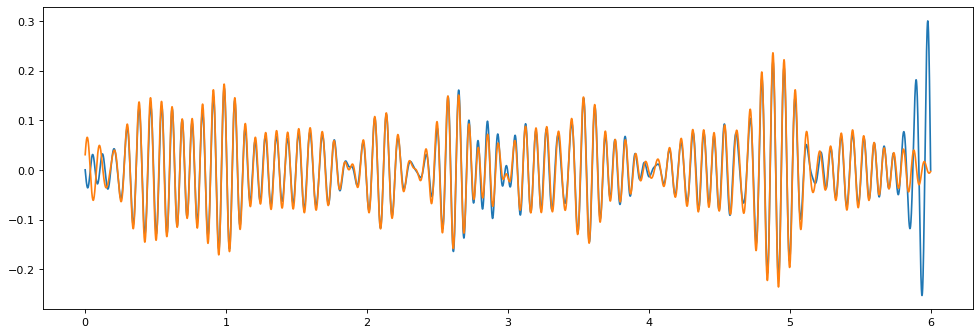

In [4]:
# import data
data = sio.loadmat('./wavelet_codeChallenge.mat')
print(data)
print(data.keys())


originalSignal = data["signal"].flatten()
signalFIR = data["signalFIR"]
signalMW = data["signalMW"]
n = len(originalSignal)
srate =  data["srate"][0][0]
print(srate)
time = np.arange(0,n)/srate

# plot
figure(figsize=(15, 5), dpi=80)
plt.plot(time,originalSignal)
plt.show()

figure(figsize=(15, 5), dpi=80)
plt.plot(time,signalFIR)
plt.plot(time,signalMW)
plt.show()

print original frequency range and target frequency range


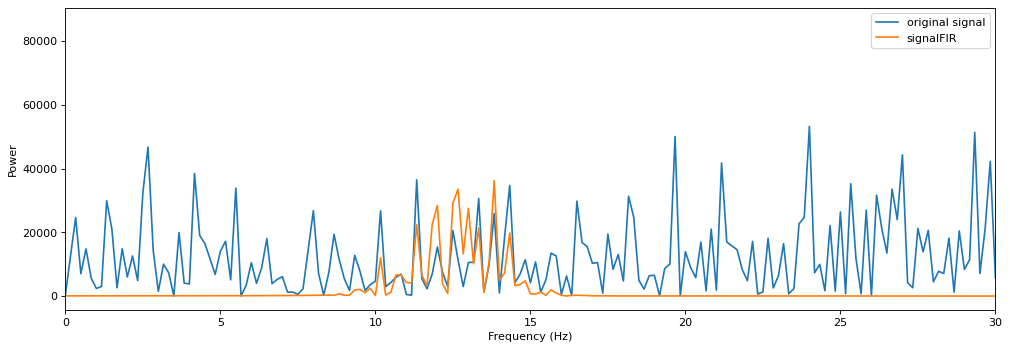

In [5]:
print(colored("print original frequency range and target frequency range", "red"))

figure(figsize=(15, 5), dpi=80)

bcpow = np.abs(scipy.fftpack.fft(originalSignal, axis=0))**2
bcpowFiltered = np.abs(scipy.fftpack.fft(signalFIR,axis=0))**2
hz = np.linspace(0, srate, len(originalSignal))

plt.plot(hz,bcpow, label='original signal')
plt.plot(hz,bcpowFiltered, label='signalFIR')

plt.legend()
plt.xlim([0,30])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.show()

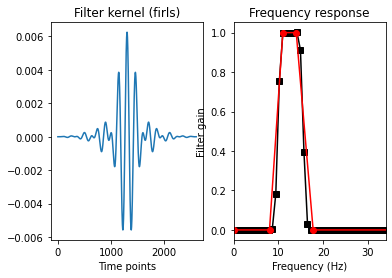

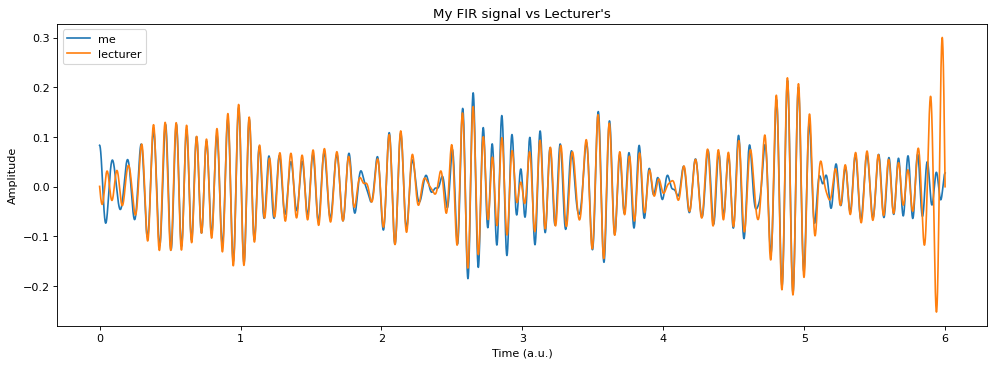

In [6]:
# define filter parameters
lower_bnd = 11 # Hz
upper_bnd = 14 # Hz

lower_trans = .27
upper_trans = .27

filtorder = 14*np.round(srate/lower_bnd)+1

filter_shape = [ 0,0,1,1,0,0 ]
filter_freqs = [ 0, lower_bnd*(1-lower_trans), lower_bnd, upper_bnd, \
                upper_bnd+upper_bnd*upper_trans,  srate/2 ]

filterkern1 = signal.firls(filtorder,filter_freqs,filter_shape,fs=srate)
hz = np.linspace(0,srate/2,int(np.floor(len(filterkern1)/2)+1))
filterpow = np.abs(scipy.fftpack.fft(filterkern1))**2


# let's see it
plt.subplot(121)
plt.plot(filterkern1)
plt.xlabel('Time points')
plt.title('Filter kernel (firls)')


# plot amplitude spectrum of the filter kernel
plt.subplot(122)
plt.plot(hz,filterpow[:len(hz)],'ks-')
plt.plot(filter_freqs,filter_shape,'ro-')

# make the plot look nicer
plt.xlim([0,upper_bnd+20])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filter gain')
plt.title('Frequency response')
plt.show()

# dealing with error "The length of the input vector x must be greater" due to data too short relatively compare with kernel 
extendedSignal = np.concatenate( (originalSignal[::-1],originalSignal,originalSignal[::-1]),axis=0 )
filteredSignalFIR = signal.filtfilt(filterkern1,1,extendedSignal)
filteredSignalFIR = filteredSignalFIR[n:2*n]

# plot time series
figure(figsize=(15, 5), dpi=80)
plt.plot(time, filteredSignalFIR,  label="me")
plt.plot(time, signalFIR,  label="lecturer")
plt.xlabel('Time (a.u.)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('My FIR signal vs Lecturer\'s')
plt.show()

detrend will make the filter frequency range correct


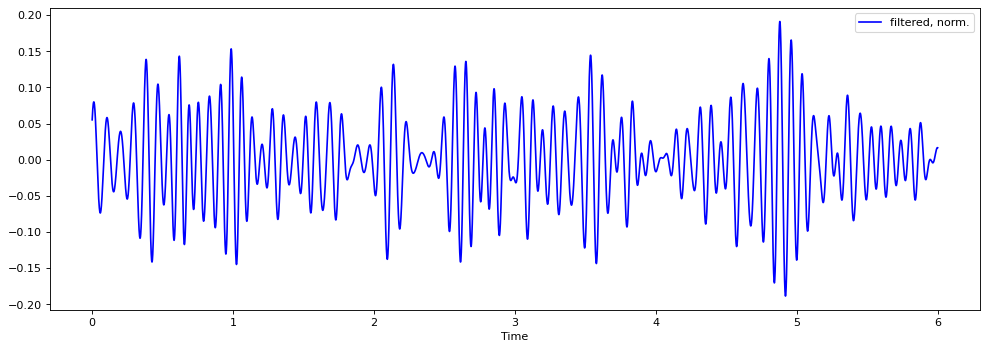

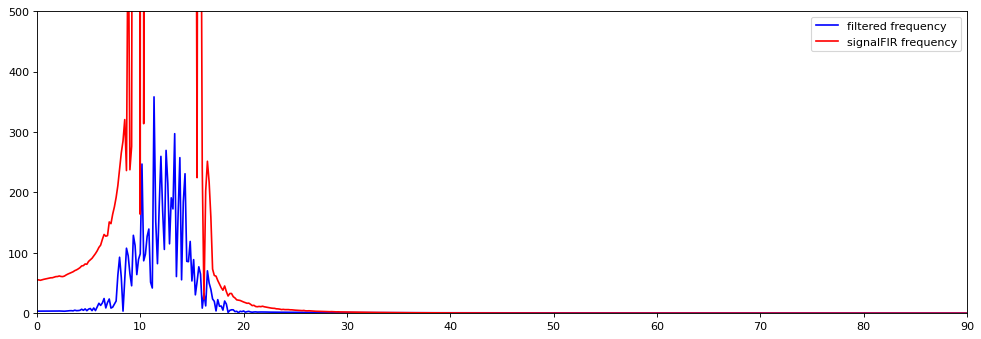

In [16]:
### "manual" convolution

# create the wavelet

# wavelet parameters
#ffreq = 12  # filter frequency in Hz
#fwhm  = .18 # full-width at half-maximum in seconds
ffreq = 12  # filter frequency in Hz
fwhm  = .15 # full-width at half-maximum in seconds
wavtime = np.arange(-3,3,1/srate) # wavelet time vector (same sampling rate as signal!)
morwav = np.cos(2*np.pi*ffreq*wavtime) * np.exp( -(4*np.log(2)*wavtime**2) / fwhm**2 )


nConv = n + len(wavtime) - 1
halfw = int( np.floor(len(wavtime)/2) )

# spectrum of wavelet
morwavX = scipy.fftpack.fft(morwav,nConv)

# now normalize in the frequency domain
## note: ensure we're taking the magnitude of the peak; 
#  I didn't explain this in the video but it ensures normalization by
#  the magnitude and not the complex value.
morwavX = morwavX / np.abs(np.max(morwavX))
# also equivalent:
# morwavX = (np.abs(morwavX)/max(np.abs(morwavX))) * np.exp(1j*np.angle(morwavX))

# now for the rest of convolution
print(colored("detrend will make the filter frequency range correct", "red"))
convres = scipy.fftpack.ifft( morwavX * scipy.fftpack.fft(scipy.signal.detrend(originalSignal),nConv) )
convres = np.real( convres[halfw:-halfw+1] )


# time domain
figure(figsize=(15, 5), dpi=80)
plt.plot(time,convres,'b',label='filtered, norm.')
plt.legend()
plt.xlabel('Time')
plt.show()

# frequency domain
hz = np.linspace(0, srate, len(originalSignal))
figure(figsize=(15, 5), dpi=80)
convresX = 2*np.abs(scipy.fftpack.fft(convres))
plt.plot(hz,convresX[:len(hz)],'b',label='filtered frequency')
plt.plot(hz,bcpowFiltered, 'r', label='signalFIR frequency')
plt.ylim([0,500])
plt.xlim([0,90])
plt.legend()
plt.show()

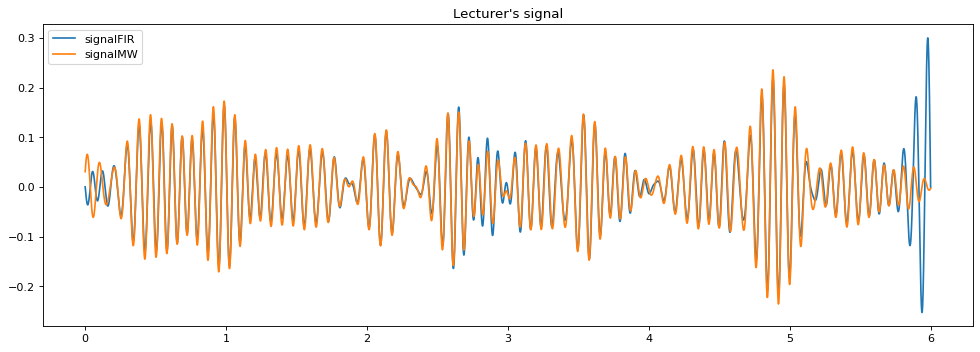

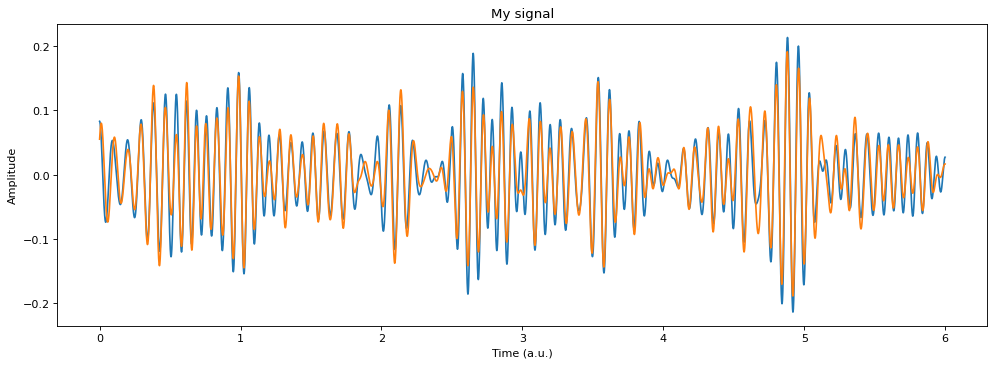

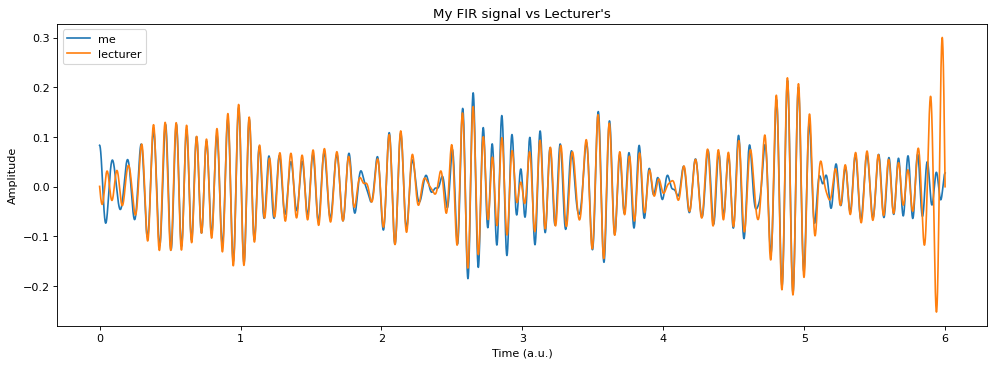

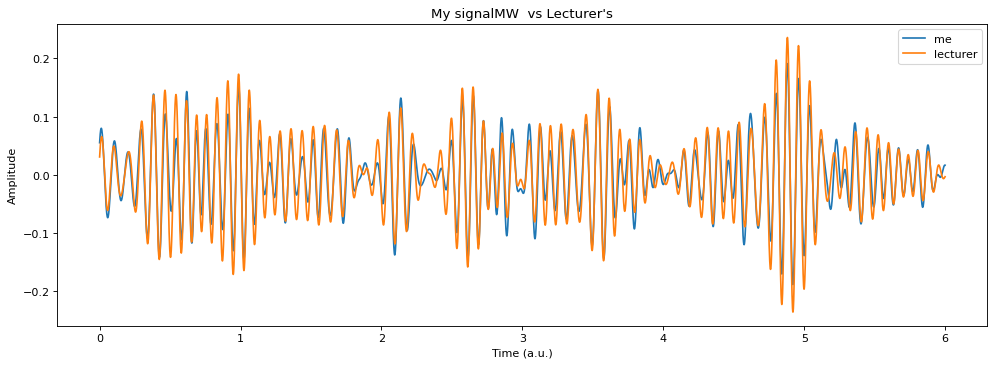

In [17]:
figure(figsize=(15, 5), dpi=80)
plt.plot(time,signalFIR, label="signalFIR")
plt.plot(time,signalMW,  label="signalMW")
plt.title('Lecturer\'s signal')
plt.legend()
plt.show()

figure(figsize=(15, 5), dpi=80)
plt.plot(time, filteredSignalFIR)
plt.plot(time, convres)
plt.xlabel('Time (a.u.)')
plt.ylabel('Amplitude')
plt.title('My signal')
plt.show()

figure(figsize=(15, 5), dpi=80)
plt.plot(time, filteredSignalFIR,  label="me")
plt.plot(time, signalFIR,  label="lecturer")
plt.xlabel('Time (a.u.)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('My FIR signal vs Lecturer\'s')
plt.show()

figure(figsize=(15, 5), dpi=80)
plt.plot(time, convres,  label="me")
plt.plot(time, signalMW,  label="lecturer")
plt.xlabel('Time (a.u.)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('My signalMW  vs Lecturer\'s')
plt.show()
